## Data import

In [2]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import NaiveBayes, LinearSVC, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
!pip install wordcloud

In [4]:
from wordcloud import WordCloud

In [5]:
ACCESS_KEY = ""
SECRET_KEY = ""
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
BUCKET_NAME = "spam"
MOUNT_NAME = "spam"

try:
  dbutils.fs.unmount("/mnt/%s/" % MOUNT_NAME)
except:
  print("Could not unmount %s for first time import." % MOUNT_NAME)

dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

path,name,size
dbfs:/mnt/spam/spam.csv,spam.csv,503663


## Preprocessing & EDA

In [7]:
spam = spark.read.format('csv')\
            .options(header='true', inferSchema='true')\
            .load('/mnt/spam/spam.csv')
display(spam)

v1,v2,_c2,_c3,_c4
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",null,null,null
ham,Ok lar... Joking wif u oni...,null,null,null
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,null,null,null
ham,U dun say so early hor... U c already then say...,null,null,null
ham,"Nah I don't think he goes to usf, he lives around here though",null,null,null
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",null,null,null
ham,Even my brother is not like to speak with me. They treat me like aids patent.,null,null,null
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,null,null,null
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,null,null,null
spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,null,null,null


In [8]:
spam.printSchema()

root
-- v1: string (nullable = true)
-- v2: string (nullable = true)
-- _c2: string (nullable = true)
-- _c3: string (nullable = true)
-- _c4: string (nullable = true)

Drop the last three columns which are not relevant for the task

In [10]:
columns_to_drop = ['_c2', '_c3', '_c4']
spam = spam.drop(*columns_to_drop)

Rename the first two columns

In [12]:
spam = spam.withColumnRenamed('v1','label')
spam = spam.withColumnRenamed('v2','text')
display(spam)

label,text
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
ham,Ok lar... Joking wif u oni...
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham,U dun say so early hor... U c already then say...
ham,"Nah I don't think he goes to usf, he lives around here though"
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv"
ham,Even my brother is not like to speak with me. They treat me like aids patent.
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [13]:
spam.count()

Out[114]: 5574

### Missing values

In [15]:
spam.where('label is NULL or text is NULL').show()

+------+----+
 label|text|
+------+----+
ham"""|null|
+------+----+

In [16]:
# Drop missing values
spam = spam.dropna()
spam.count()

Out[117]: 5573

Reformat labels

In [18]:
spam.select('label').distinct().show()

+------+
 label|
+------+
ham"""|
 ham|
 spam|
+------+

In [19]:
spam = spam.withColumn('label', regexp_replace('label', '"""', ''))

In [20]:
spam.select('label').distinct().show()

+-----+
label|
+-----+
 ham|
 spam|
+-----+

### Class balance

In [22]:
spam.groupby('label').count().show()

+-----+-----+
label|count|
+-----+-----+
 ham| 4826|
 spam| 747|
+-----+-----+

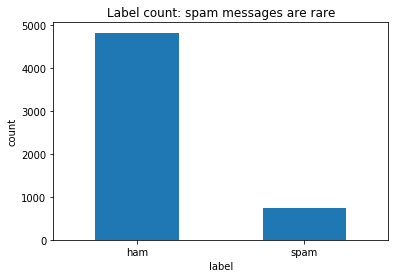

In [23]:
label_count = spam.groupby('label').count().toPandas()
label_count.plot(x='label', y='count', kind='bar', legend=None)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.title('Label count: spam messages are rare')

### Wordcloud

In [25]:
def plot_wordcloud(df, label):
  condition = 'label=\"' + label + '\"'
  print(condition)
  text = df.filter(condition)\
           .select('text')\
           .rdd.flatMap(lambda x: x)\
           .collect() # list of strings
  text = ''.join(str(t) for t in text) # string
  
  wordcloud = WordCloud(max_font_size=50, 
                        max_words=100, 
                        background_color='white').generate(text)

  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(label, fontsize=15)
  plt.show()

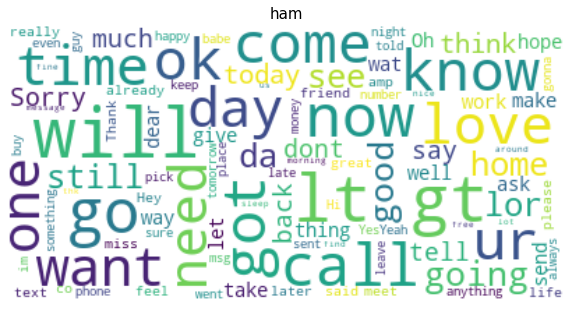

In [26]:
plot_wordcloud(spam, 'ham')

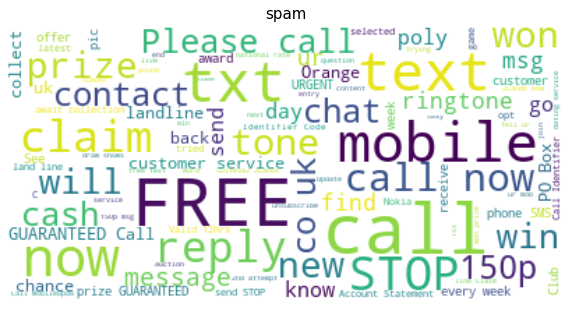

In [27]:
plot_wordcloud(spam, 'spam')

- Non-spam messages: sentiment words (e.g., love, good, ok, sorry)
- Spam messages: ad-related words (e.g., free, prize, claim, cash)

### Message length

In [30]:
spam = spam.withColumn('length', length('text'))

In [31]:
spam.show(5)

+-----+--------------------+------+
label| text|length|
+-----+--------------------+------+
 ham|Go until jurong p...| 111|
 ham|Ok lar... Joking ...| 29|
 spam|Free entry in 2 a...| 155|
 ham|U dun say so earl...| 49|
 ham|Nah I don't think...| 61|
+-----+--------------------+------+
only showing top 5 rows

In [32]:
spam.groupby('label').agg(min('length'), max('length'), avg('length')).show()

+-----+-----------+-----------+------------------+
label|min(length)|max(length)| avg(length)|
+-----+-----------+-----------+------------------+
 ham| 2| 910| 71.07065893079155|
 spam| 13| 223|138.45917001338688|
+-----+-----------+-----------+------------------+

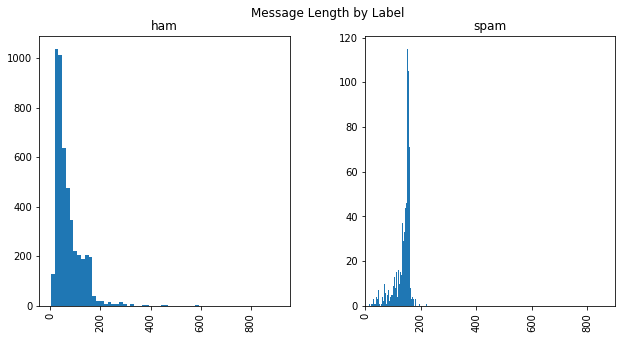

In [33]:
length = spam.select('label', 'length').toPandas()
length.hist(column='length', by='label', bins=60, figsize=(10, 5))
plt.suptitle('Message Length by Label')
plt.xlim(0, 900)

Spam messages seem to be longer.

### Train-test-split

In [36]:
SEED=42
train, test = spam.randomSplit([0.8, 0.2], seed=SEED)

In [37]:
train.count(), test.count()

Out[131]: (4502, 1071)

### Text preprocessing
- Tokenization
- Vectorization (HashingTF)
- TF-IDF weighting

### Label preprocessing
- Map labels to numerical indices

The preprocessing steps will be integrated in the model pipeline and tuned.

## Model

In [41]:
def fit_model(model, train=train, test=test, results=False,
              num_folds=5, tuning=False, param_grid=None):
  
  tokenizer = Tokenizer(inputCol='text', outputCol='words')
  hashingTF = HashingTF(inputCol='words', outputCol='tf', numFeatures=10000)
  idf = IDF(inputCol='tf', outputCol='tfidf')
  label_indexer = StringIndexer(inputCol='label',outputCol='label_index')
  
  pipeline = Pipeline(stages=[tokenizer,
                              hashingTF,
                              idf,
                              label_indexer,
                              model])
  
  evaluator = MulticlassClassificationEvaluator(labelCol='label_index', 
                                                predictionCol='prediction',
                                                metricName='accuracy')
  
  if tuning:
    pipeline = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=num_folds) 
    pipeline = pipeline.fit(train)
    predictions = pipeline.bestModel.transform(test)
  else: 
    pipeline = pipeline.fit(train)
    predictions = pipeline.transform(test)
  
  acc = evaluator.evaluate(predictions)
  print(f'Test set accuracy: {100*acc:.2f}')
  
  if results:
    return pipeline, predictions

### Naive Bayes

In [43]:
nb = NaiveBayes(labelCol='label_index', featuresCol='tfidf')
fit_model(nb)

Test set accuracy: 94.96

### SVM

In [45]:
svm = LinearSVC(labelCol='label_index', featuresCol='tfidf')
fit_model(svm)

Test set accuracy: 97.57

### Decision Tree

In [47]:
dt = DecisionTreeClassifier(labelCol='label_index', featuresCol='tfidf', 
                            seed=SEED)
fit_model(dt)

Test set accuracy: 94.49

### Gradient-boosted Tree

In [49]:
gbt = GBTClassifier(labelCol='label_index', featuresCol='tfidf', 
                    seed=SEED)
fit_model(gbt)

Test set accuracy: 95.52

SVM and Naive Bayes have better performances and are more efficient in terms of runtime. 

Indeed, these are among the most popular classifiers for spam detection.

### Tuning SVM

In [52]:
param_grid = ParamGridBuilder()\
  .addGrid(hashingTF.numFeatures, [1000, 10000])\
  .addGrid(idf.minDocFreq, [2, 4])\
  .addGrid(svm.maxIter, [5, 10])\
  .addGrid(svm.regParam, [0.1, 0.01])\
  .build()

In [53]:
svm_cv, predictions = fit_model(svm, results=True, tuning=True, param_grid=param_grid)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Test set accuracy: 97.67

In [54]:
predictions.select('label_index', 'prediction')\
  .filter('label_index = 1')\
  .show(10)

+-----------+----------+
label_index|prediction|
+-----------+----------+
 1.0| 0.0|
 1.0| 0.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 0.0|
+-----------+----------+
only showing top 10 rows